In [0]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from basic_rnn import RNN
from transformer_model import TransformerModel

env = gym.make('CartPole-v0').unwrapped
torch.manual_seed(123)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
pretrained_hidden_size = 100
NHEAD = 5
obs_size = env.observation_space.shape[0]

embed_size = math.floor(pretrained_hidden_size / 2)
embed_model = RNN(obs_size, pretrained_hidden_size, obs_size)
embed_model.load_state_dict(torch.load('rnn_save_state_50.torch'))
#embed_size = pretrained_hidden_size
#embed_model = TransformerModel(obs_size, obs_size, NHEAD, pretrained_hidden_size, 1, 0)
#embed_model.load_state_dict(torch.load('transformer_layer1_hid50.torch'))
embed_model.double()
embed_model.to(device)
embed_model.eval()

RNN(
  (rnn): RNN(4, 100, batch_first=True)
  (lin1): Linear(in_features=100, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=4, bias=True)
)

In [0]:
class DQN(nn.Module):

    def __init__(self, input_size):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(input_size, 100).double()
        self.bn1 = nn.LayerNorm(100).double()
        self.head = nn.Linear(100, env.action_space.n).double()

    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = F.relu(x)
        return self.head(x)

In [0]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN(embed_size).to(device)
target_net = DQN(embed_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1000000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            temp = policy_net(state)
            temp = temp.sum(dim=0)
            return temp.max(0)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []
episode_rewards = []

def plot_durations():
    if len(episode_durations) >= 100:
      print(np.mean(episode_durations[-99:]))
    else:
      print(np.mean(episode_durations))

def plot_rewards():
    if len(episode_rewards) >= 100:
      return (np.mean(episode_rewards[-99:]))
    else:
      return (np.mean(episode_rewards))

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device, dtype=torch.double)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [7]:
saved_episodes = []
num_episodes = 1000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = torch.zeros(embed_size, dtype=torch.double).to(device)
    last_screen = last_screen.unsqueeze(0)
    current_screen = torch.zeros(embed_size, dtype=torch.double).to(device)
    current_screen = current_screen.unsqueeze(0)
    episode = torch.tensor([], dtype=torch.double).to(device)
    state = current_screen - last_screen
    reward_total = 0
    cur_episode = []
    for t in count():
        # Select and perform an action
        action = select_action(state)
        raw_obs, reward, done, _ = env.step(action.item())
        raw_obs = torch.tensor(raw_obs, dtype=torch.double, requires_grad=False).view(1, 1, -1)
        raw_obs = raw_obs.to(device)
        episode = torch.cat([episode, raw_obs], dim=1).to(device)
        embed_obs = embed_model.embed(episode)[0, -1, :]
        obs = embed_obs.clone().detach().requires_grad_(True)
        reward_total += reward
        reward = torch.tensor([reward], device=device)
        cur_episode.append(obs)
        # Observe new state
        last_screen = current_screen
        current_screen = obs
        current_screen = current_screen.unsqueeze(0)
        if len(current_screen.shape) > 2:
            raise
        if t == 199:
          done = True
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            saved_episodes.append(cur_episode)
            episode_rewards.append(reward_total)
            episode_durations.append(t + 1)
            break
    if i_episode % 10 == 0:
        print(f' {i_episode}: {plot_rewards()}')
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
#env.render()
#env.close()
plt.ioff()
plt.show()

 0: 17.0
 10: 23.454545454545453
 20: 26.714285714285715
 30: 26.870967741935484
 40: 27.21951219512195
 50: 26.41176470588235
 60: 26.19672131147541
 70: 24.943661971830984
 80: 24.123456790123456
 90: 23.384615384615383
 100: 23.575757575757574
 110: 24.95959595959596
 120: 25.04040404040404
 130: 25.07070707070707
 140: 25.818181818181817
 150: 28.727272727272727
 160: 31.08080808080808
 170: 34.21212121212121
 180: 37.09090909090909
 190: 39.57575757575758
 200: 39.08080808080808
 210: 38.15151515151515
 220: 38.05050505050505
 230: 40.696969696969695
 240: 39.14141414141414
 250: 37.98989898989899
 260: 38.56565656565657
 270: 41.303030303030305
 280: 43.82828282828283
 290: 43.717171717171716
 300: 44.55555555555556
 310: 44.55555555555556
 320: 47.343434343434346
 330: 47.878787878787875
 340: 47.42424242424242
 350: 52.282828282828284
 360: 47.72727272727273
 370: 45.13131313131313
 380: 43.64646464646464
 390: 44.95959595959596
 400: 48.60606060606061
 410: 50.84848484848485
 

In [8]:
moving_average = []
for i in range(len(episode_rewards)):
    if i < 50:
      moving_average.append(np.mean(episode_rewards[:i]))
    else:
      moving_average.append(np.mean(episode_rewards[i-50:i]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


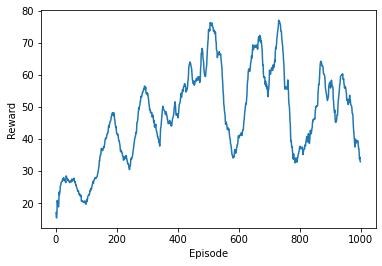

In [9]:
plt.plot(moving_average)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [10]:
print(len(saved_episodes))
print(type(saved_episodes[0][0]))
print(max([len(x) for x in saved_episodes]))

1000
<class 'torch.Tensor'>
200


In [0]:
"""output_array = []
for i in range(len(saved_episodes)):
    temp = np.expand_dims(np.full((200, 4), -999, dtype='float64'), 0)
    episode = np.array(saved_episodes[i])
    temp[0, :len(saved_episodes[i]), :] = episode
    output_array.append(temp)
output_array = np.concatenate(output_array)"""
output_array = np.array(saved_episodes, dtype=object)